Starting analysis...

Loading quiz, submission, and historical data...

Fetching data from https://www.jsonkeeper.com/b/LLQT...

Data fetched successfully from https://www.jsonkeeper.com/b/LLQT

Fetching data from https://api.jsonserve.com/rJvd7g...

Data fetched successfully from https://api.jsonserve.com/rJvd7g

Fetching data from https://api.jsonserve.com/XgAgFJ...

Data fetched successfully from https://api.jsonserve.com/XgAgFJ

Data loaded successfully.

Analyzing current quiz data...

Current quiz analysis:
Topic: Structural Organisation in Animals
Accuracy: 80.0%
Total Questions: 128

Analyzing historical data...

Historical data analysis complete. Data shape: (14, 5)

Data after one-hot encoding: (14, 12)

Generating personalized insights...

Current quiz topic: Structural Organisation in Animals | Accuracy: 80.0%

Average accuracy by topic: 
{
  "topic_Body Fluids and Circulation ": 80.0,
  "topic_Human Reproduction": 38.0,
  "topic_Reproductive Health": 43.0,
  "topic_Respira

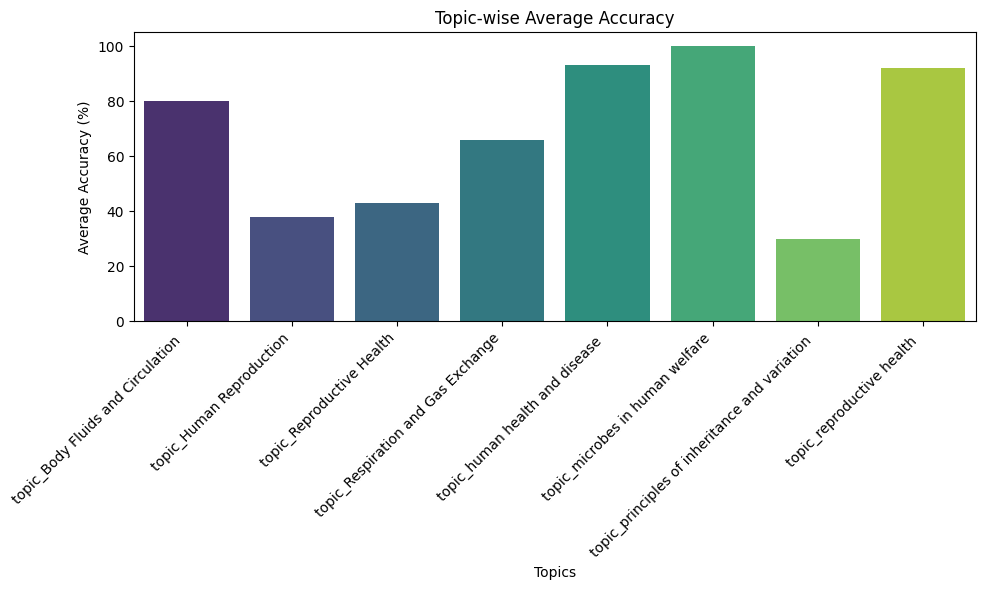


Analysis complete.



In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# API Endpoints
QUIZ_ENDPOINT = "https://www.jsonkeeper.com/b/LLQT"
QUIZ_SUBMISSION_ENDPOINT = "https://api.jsonserve.com/rJvd7g"
API_ENDPOINT = "https://api.jsonserve.com/XgAgFJ"

# Fetch Data from APIs
def fetch_json_data(url):
    print(f"Fetching data from {url}...\n")
    response = requests.get(url)
    response.raise_for_status()
    print(f"Data fetched successfully from {url}\n")
    return response.json()

# Load Data
def load_data():
    print("Loading quiz, submission, and historical data...\n")
    quiz_data = fetch_json_data(QUIZ_ENDPOINT)
    quiz_submission_data = fetch_json_data(QUIZ_SUBMISSION_ENDPOINT)
    historical_data = fetch_json_data(API_ENDPOINT)
    print("Data loaded successfully.\n")
    return quiz_data, quiz_submission_data, historical_data

# Analyze Current Quiz Data
def analyze_current_quiz(quiz_submission):
    print("Analyzing current quiz data...\n")
    total_questions = quiz_submission["total_questions"]
    correct_answers = quiz_submission["correct_answers"]
    incorrect_answers = quiz_submission["incorrect_answers"]
    accuracy = float(quiz_submission["accuracy"].strip('%'))
    topic = quiz_submission["quiz"]["topic"]
    response_map = quiz_submission["response_map"]

    detailed_feedback = []

    # Check if 'questions' key exists
    if "questions" in quiz_submission["quiz"]:
        for question_id, response_id in response_map.items():
            question = next((q for q in quiz_submission["quiz"]["questions"] if q["id"] == question_id), None)
            if question:
                user_response = next((opt["description"] for opt in question["options"] if opt["id"] == response_id), None)
                correct_answer = next((opt["description"] for opt in question["options"] if opt["is_correct"]), None)
                detailed_solution = question.get("detailed_solution", "No detailed solution available.")
                feedback = {
                    "question_id": question_id,
                    "question": question["description"],
                    "user_response": user_response,
                    "correct_answer": correct_answer,
                    "correct": user_response == correct_answer,
                    "detailed_solution": detailed_solution
                }
                detailed_feedback.append(feedback)

    print(f"Current quiz analysis:\n"
          f"Topic: {topic}\n"
          f"Accuracy: {accuracy}%\n"
          f"Total Questions: {total_questions}\n")
    
    return {
        "topic": topic,
        "total_questions": total_questions,
        "correct_answers": correct_answers,
        "incorrect_answers": incorrect_answers,
        "accuracy": accuracy,
        "detailed_feedback": detailed_feedback
    }

# Analyze Historical Data
def analyze_historical_data(historical_data):
    print("Analyzing historical data...\n")
    analysis = []
    comparative_analysis = {}

    for record in historical_data:
        topic = record["quiz"]["topic"]
        accuracy = float(record["accuracy"].strip('%'))
        total_questions = record["total_questions"]
        correct_answers = record["correct_answers"]
        incorrect_answers = record["incorrect_answers"]
        better_than = record.get("better_than", 0)
        rank_text = record.get("rank_text", "N/A")
        quiz_id = record["quiz"]["id"] # Add quiz_id here

        comparative_analysis[record["id"]] = {
            "score": record["score"],
            "accuracy": accuracy,
            "total_questions": total_questions,
            "correct_answers": correct_answers,
            "incorrect_answers": incorrect_answers,
            "better_than": better_than,
            "rank_text": rank_text,
            "quiz_id": quiz_id # Include quiz_id in the comparative_analysis
        }

        analysis.append({
            "topic": topic,
            "accuracy": accuracy,
            "total_questions": total_questions,
            "correct_answers": correct_answers,
            "incorrect_answers": incorrect_answers
        })

    df = pd.DataFrame(analysis)
    print(f"Historical data analysis complete. Data shape: {df.shape}\n")
    
    # One-hot encoding for topic
    df = pd.get_dummies(df, columns=["topic"], drop_first=True)
    print(f"Data after one-hot encoding: {df.shape}\n")
    
    return df, comparative_analysis

# Generate Personalized Insights
def generate_insights(current_analysis, historical_analysis):
    print("Generating personalized insights...\n")
    insights = {
        "weak_areas": [],
        "strong_areas": [],
        "improvement_trends": []
    }

    current_topic = current_analysis["topic"]
    current_accuracy = current_analysis["accuracy"]
    print(f"Current quiz topic: {current_topic} | Accuracy: {current_accuracy}%\n")

    # Calculate average accuracy by topic
    topic_columns = [col for col in historical_analysis.columns if col.startswith('topic_')]
    topic_avg_accuracy = historical_analysis[topic_columns].multiply(historical_analysis['accuracy'], axis=0).sum() / historical_analysis[topic_columns].sum()

    print(f"Average accuracy by topic: \n{json.dumps(topic_avg_accuracy.to_dict(), indent=2)}\n")

    for topic, avg_accuracy in topic_avg_accuracy.items():
        if avg_accuracy < 60:
            insights["weak_areas"].append((topic, avg_accuracy))
        elif avg_accuracy > 80:
            insights["strong_areas"].append((topic, avg_accuracy))

        # Improvement trend analysis for the current topic
        if current_topic in topic:
            if current_accuracy > avg_accuracy:
                insights["improvement_trends"].append(f"You improved in {topic}. Keep it up!")
            else:
                insights["improvement_trends"].append(f"Your accuracy in {topic} dropped. Focus on this topic!")

    print(f"Generated insights: \n{json.dumps(insights, indent=2)}\n")
    return insights

# Provide Recommendations
def provide_recommendations(insights, comparative_analysis):
    print("Providing recommendations based on insights and comparative analysis...\n")
    recommendations = []
    for topic, accuracy in insights["weak_areas"]:
        recommendations.append(f"Focus more on {topic} as the average accuracy is {accuracy:.2f}%.")

    # Include comparative analysis in recommendations
    for record_id, comp_data in comparative_analysis.items():
        recommendations.append(f"For quiz ID {comp_data['quiz_id']}: Your accuracy was {comp_data['accuracy']}%, better than {comp_data['better_than']} other participants. {comp_data['rank_text']}")

    print(f"Generated recommendations: \n{json.dumps(recommendations, indent=2)}\n")
    return recommendations


# Generate Student Labels Based on Performance
def generate_labels(insights):
    print("Generating student labels based on performance...\n")
    labels = []

    # Define labels based on weak and strong areas
    if len(insights["weak_areas"]) > 0 and len(insights["strong_areas"]) > 0:
        labels.append("Balanced Learner: You have both strengths and areas to improve.")
    if len(insights["weak_areas"]) == 0:
        labels.append("Master of Topics: Great work! You've mastered all topics.")
    if len(insights["strong_areas"]) == 0:
        labels.append("Needs Improvement: Focus on the weak areas to improve performance.")
    
    # Add specific labels for conceptual learners or speedy solvers
    if any([accuracy > 80 for topic, accuracy in insights["strong_areas"]]):
        labels.append("Conceptual Learner: You excel in conceptual topics.")
    
    if any([accuracy < 40 for topic, accuracy in insights["weak_areas"]]):
        labels.append("Needs Attention: Focus more on topics with low accuracy.")
    
    # Create label based on performance consistency
    if len(insights["improvement_trends"]) > 0:
        labels.append("Improvement Seeker: Keep up the great work and continue improving!")
    else:
        labels.append("Consistent Performer: You maintain a steady performance, but there's room to grow.")

    print(f"Generated labels: \n{json.dumps(labels, indent=2)}\n")
    return labels

# Visualize Topic-wise Accuracy
def plot_topic_accuracy(historical_analysis):
    print("Generating topic accuracy plot...\n")
    topic_columns = [col for col in historical_analysis.columns if col.startswith('topic_')]
    topic_avg_accuracy = historical_analysis[topic_columns].multiply(historical_analysis['accuracy'], axis=0).sum() / historical_analysis[topic_columns].sum()

    print(f"Topic-wise average accuracy: \n{json.dumps(topic_avg_accuracy.to_dict(), indent=2)}\n")

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_avg_accuracy.index, y=topic_avg_accuracy.values, hue=topic_avg_accuracy.index, palette="viridis", legend=False)
    plt.title("Topic-wise Average Accuracy")
    plt.xlabel("Topics")
    plt.ylabel("Average Accuracy (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("topic_accuracy.png")
    plt.show()

# Main Execution
if __name__ == "__main__":
    print("Starting analysis...\n")
    quiz_data, quiz_submission_data, historical_data = load_data()

    # Analyze current quiz and historical data
    current_analysis = analyze_current_quiz(quiz_submission_data)
    historical_analysis, comparative_analysis = analyze_historical_data(historical_data)

    # Generate insights based on current quiz and historical performance
    insights = generate_insights(current_analysis, historical_analysis)
    recommendations = provide_recommendations(insights, comparative_analysis)

    # Generate student labels
    labels = generate_labels(insights)

    # Display Insights
    print("\n--- Current Quiz Analysis ---")
    print(f"Topic: {current_analysis['topic']}\n"
          f"Accuracy: {current_analysis['accuracy']}%\n")

    print("\n--- Insights ---")
    print(f"Weak Areas: {json.dumps(insights['weak_areas'], indent=2)}\n")
    print(f"Strong Areas: {json.dumps(insights['strong_areas'], indent=2)}\n")
    print(f"Improvement Trends: {json.dumps(insights['improvement_trends'], indent=2)}\n")

    print("\n--- Recommendations ---")
    print(json.dumps(recommendations, indent=2))

    print("\n--- Student Labels ---")
    print(json.dumps(labels, indent=2))

    # Plot Topic Accuracy
    plot_topic_accuracy(historical_analysis)

    print("\nAnalysis complete.\n")
